In [1]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skewnorm
from lmfit import Model, Parameters
from lmfit.models import GaussianModel, SkewedGaussianModel
from source.services.fits_data_unpack_service import FitsDataUnpackService
from source.services.fits_file_load_service import FitsFileLoadService
from source.util import lekid_analysis_tools
from source.util import data_array_analysis_tools
from source.util import scatter_tools

In [2]:
directory = r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\slim_v2_anlw001_idc_stepdown\Data\20230815_Dark_Data_Prelim\VNA_Sweeps"
filename = "S21_Segmented_BTEMP0000_mK_POW0.0_dB_ATT50.0_dB.fits"
file_path = os.path.join(directory, filename)
expected_f0_filepath = r"C:\Python_Projects\Analysis\general_device_analysis\scripts\device_specific_scripts\spt_slim_v2_anlw001_idc_stepdown\trio_f0_array.txt"

fit_model = "skewed"  # Boolean to define which model is used for fitting, "skewed" or "non-linear"
plot_fits = False  # Boolean to plot each kids fit.
save_figures = False  # Boolean to save the plots.
show_kid_labels = True  # Boolean to add kid labels to the segmented vna sweep plot.
qr_mask_min_bound = 0.0
qr_mask_max_bound = 1e7
qc_mask_min_bound = 0.0
qc_mask_max_bound = 1e7
qi_mask_min_bound = 0.0
qi_mask_max_bound = 1e6


Sweep Data Missing Field: SETBASET
Number of KID tones: 355
Data file attenuation values:
Room temperature attenuation = 2.0
Variable Room temperature attenuation = 50.0dB
Cold attenuation = 20.0dB
Ultra-cold attenuation = 10.0dB
Output attenuation = 0.0dB
Total Amplifier Gain = 0dB
KID72: Qi = 1.07E+06
KID73: Qi = 1.64E+06
KID114: Qi = 1.08E+06
KID117: Qi = 8.42E+06
KID127: Qi = 1.16E+06
KID139: Qi = 1.35E+06
KID171: Qi = 5.78E+06
KID172: Qi = 1.02E+06
KID268: Qi = 9.52E+06
KID277: Qi = 1.16E+06
KID282: Qi = 1.18E+06
KID322: Qi = 1.02E+06
KID325: Qi = 1.20E+06
KID334: Qi = 1.03E+06
KID354: Qi = 1.04E+06


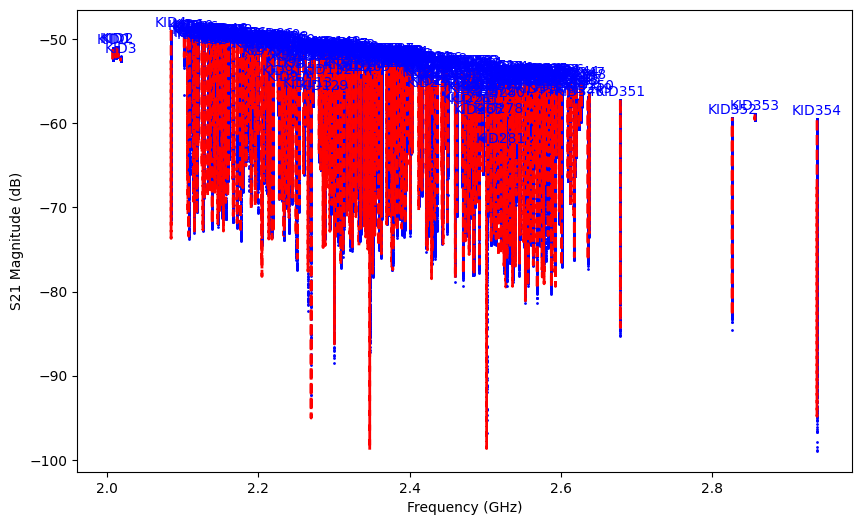

In [3]:

fits_vna_sweep = FitsFileLoadService.load_fits_vna_sweep_file(file_path=file_path)
frequency_array = fits_vna_sweep.data.frequency_array
s21_complex = fits_vna_sweep.data.get_iq_array()

number_of_tones = fits_vna_sweep.header.number_of_tones
print(f"Number of KID tones: {number_of_tones}")
fits_vna_sweep.header.print_attenuation_values()

# Split data into sub arrays corresponding to each kid:
frequency_array = np.split(frequency_array, number_of_tones)
s21_magnitude = np.abs(np.split(s21_complex, number_of_tones))

f0_array = []
qr_array = []
qc_array = []
qi_array = []

plt.figure(figsize=(10, 6))
for count, kid_s21 in enumerate(s21_magnitude):
    plt.plot(
        frequency_array[count] * 1e-9,
        20 * np.log10(kid_s21),
        linestyle="none",
        marker="o",
        color="b",
        markersize="1",
    )
    if show_kid_labels:
        plt.text(
            np.median(frequency_array[count]) * 1e-9,
            np.max(20 * np.log10(kid_s21)) + 0.5,
            f"KID{count}",
            fontsize=10,
            color="b",
            horizontalalignment="center",
        )

    # TODO: Add logic to rerun fit with different Q if errors are too large.
    if fit_model == "skewed":
        fit_result_dict = lekid_analysis_tools.fit_skewed_lorentzian(
            frequency_array=frequency_array[count],
            data_array=kid_s21,
            qc_guess=1e5,
            qi_guess=1e5,
            f0_guess=None,
            fit_fraction=0.9,
            normalise=False,
            plot_db=True,
            plot_title=f"Skewed (Pete fitter) fit: KID {count}",
            plot_graph=False,
        )
        s21_fit = lekid_analysis_tools.skewed_lorentzian(
            frequency_array=frequency_array[count],
            f0=fit_result_dict["f0"][0],
            qi=fit_result_dict["qi"][0],
            qc_real=fit_result_dict["qc_real"][0],
            qc_imag=fit_result_dict["qc_imag"][0],
            amp=fit_result_dict["amp"][0],
        )
        plt.plot(
            frequency_array[count] * 1e-9,
            20 * np.log10(s21_fit),
            linewidth=2,
            linestyle="--",
            color="r",
        )

        if fit_result_dict["qi"][0] > 1e6:
            qi = fit_result_dict["qi"][0]
            print(f"KID{count}: Qi = {qi:.2E}")

    # Store f0 and quality factor data.
    f0_array.append(fit_result_dict["f0"][0])
    qr_array.append(fit_result_dict["qr"][0])
    qc_array.append(fit_result_dict["qc"][0])
    qi_array.append(fit_result_dict["qi"][0])

plt.xlabel("Frequency (GHz)")
plt.ylabel("S21 Magnitude (dB)")
if save_figures:
    plt.savefig(
        "..\\..\\Figures\\"
        + f"{fits_vna_sweep.header.dut}_segmented_vna_sweep_KID_Fits"
    )
plt.show()

f0_array = np.array(f0_array)
qr_array = np.array(qr_array)
qc_array = np.array(qc_array)
qi_array = np.array(qi_array)


In [4]:
# Get expected f0 array:
expected_f0_array = np.sort(np.concatenate(np.loadtxt(expected_f0_filepath, delimiter=",")))
n_tones_expected = expected_f0_array.size

min_frequency = 2.1e9
max_frequency = 2.635e9

mask = np.where((f0_array > min_frequency) & (f0_array < max_frequency))[0]
print(f"Tones within range = {mask.size}")
reduced_f0_array = f0_array[mask]
reduced_qr_array = qr_array[mask]

uncertainty = 1/np.sqrt(f0_array.size)


Tones within range = 344


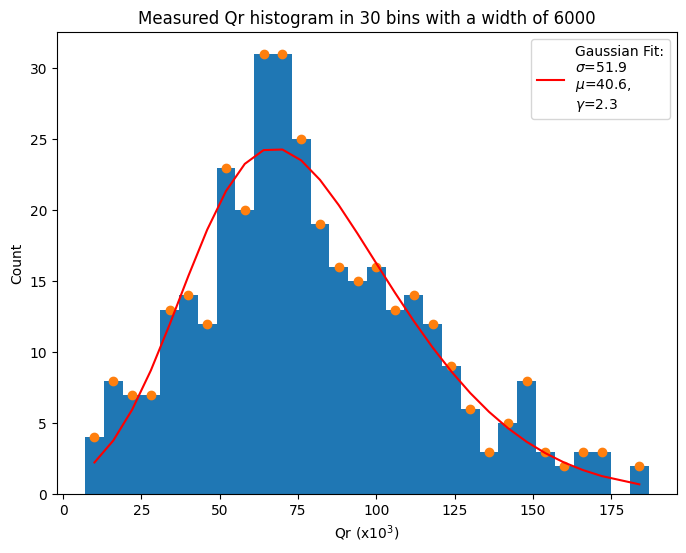

In [5]:
minimum_bin = math.floor(np.min(reduced_qr_array * 1e-3))
maximum_bin = math.ceil(np.max(reduced_qr_array * 1e-3))
qr_range = int((maximum_bin - minimum_bin) / 6)

counts, bins = np.histogram(reduced_qr_array*1e-3, bins=qr_range, range=(minimum_bin, maximum_bin))
qr_values = bins[:-1] + (bins[1] - bins[0]) / 2
non_zeros = np.where(counts != 0)[0]
non_zero_counts = counts[non_zeros]
non_zero_qr_values = qr_values[non_zeros]

# Fit gaussian:
model = SkewedGaussianModel()
parameters = model.guess(non_zero_counts, x=non_zero_qr_values)
result = model.fit(non_zero_counts, parameters, x=non_zero_qr_values)
qr_sigma=result.best_values["sigma"]
qr_centre=result.best_values["center"]
qr_gamma=result.best_values["gamma"]

plt.figure(figsize=(8, 6))
plt.hist(reduced_qr_array * 1e-3, bins=qr_range, range=(minimum_bin, maximum_bin))
plt.plot(non_zero_qr_values, non_zero_counts, linestyle="none", marker="o",)
plt.plot(non_zero_qr_values, result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={qr_sigma:.1f}\n$\mu$={qr_centre:.1f},\n$\gamma$={qr_gamma:.1f}")
plt.legend()
plt.xlabel("Qr (x10$^3$)")
plt.ylabel("Count")
plt.title(f"Measured Qr histogram in {qr_range} bins with a width of {(bins[1] - bins[0])*1e3:.0f}")
plt.show()

In [6]:
# Create fake data:
device_yield = reduced_f0_array.size / n_tones_expected
print(f"Device yield: {device_yield}")
fractional_frequency_shift = 0.001
line_width_spacing_threshold = 10

# Create fake scattered array:

fake_scattered_array = scatter_tools.randomize_f0_array(
    f0_array=expected_f0_array,
    fab_yield=device_yield,
    fractional_frequency_shift=fractional_frequency_shift,
    plot_f0_arrays=False
)

fake_qr_array = np.abs(skewnorm.rvs(a=qr_gamma, loc=qr_centre, scale=qr_sigma, size=fake_scattered_array.size)) * 1e3



Device yield: 0.882051282051282


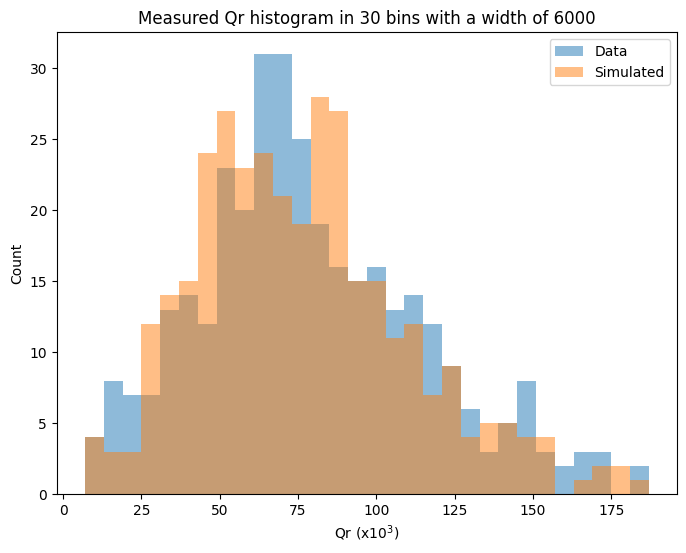

In [7]:
fake_minimum_bin = math.floor(np.min(fake_qr_array * 1e-3))
fake_maximum_bin = math.ceil(np.max(fake_qr_array * 1e-3))
fake_qr_range = int((maximum_bin - minimum_bin) / 8)

plt.figure(figsize=(8, 6))
plt.hist(reduced_qr_array * 1e-3, bins=qr_range, range=(minimum_bin, maximum_bin), alpha=0.5, label="Data")
plt.hist(fake_qr_array * 1e-3, bins=qr_range, range=(minimum_bin, maximum_bin), alpha=0.5, label="Simulated")
plt.legend()
plt.xlabel("Qr (x10$^3$)")
plt.ylabel("Count")
plt.title(f"Measured Qr histogram in {qr_range} bins with a width of {(bins[1] - bins[0])*1e3:.0f}")
plt.show()

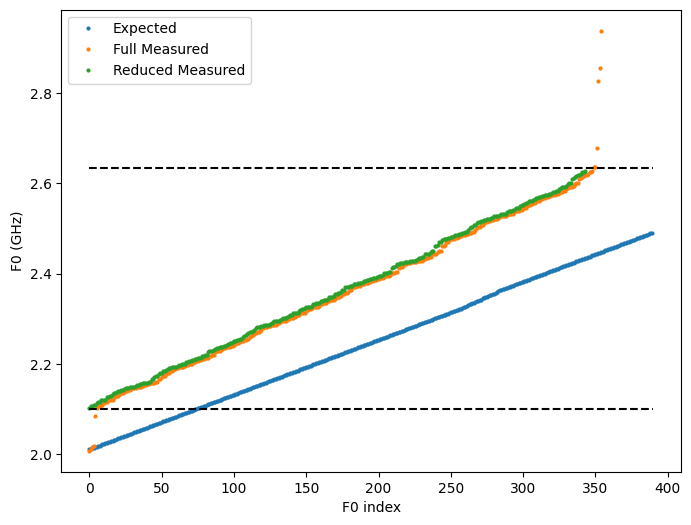

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(expected_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Expected")
plt.plot(f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Full Measured")
plt.plot(reduced_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Reduced Measured")
# plt.plot(fake_scattered_array*1e-9, linestyle="none", marker="o", markersize=2, label="Simulated")
plt.hlines(y=[min_frequency*1e-9, max_frequency*1e-9], xmin=0, xmax=expected_f0_array.size, color="k", linestyles="--")
plt.xlabel("F0 index")
plt.ylabel("F0 (GHz)")
plt.legend()
plt.show()

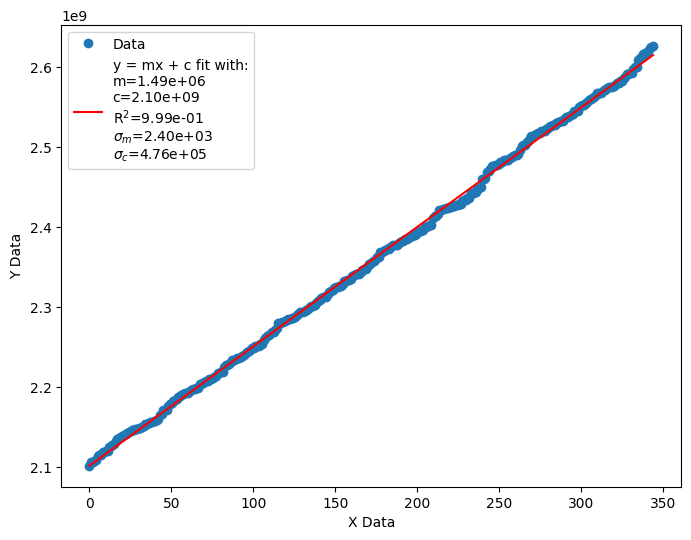

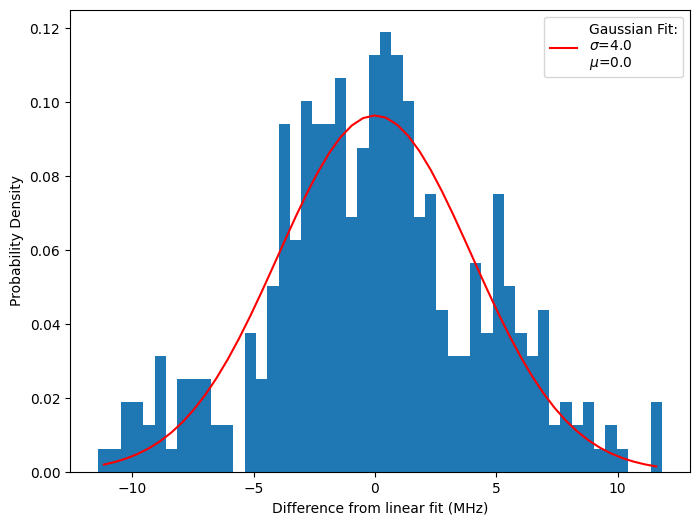

In [9]:
# Fit linear to reduced f0 array to get an approximate sigma value.

import source.util.general_analysis_tools as general_analysis_tools

index_values = np.linspace(0, reduced_f0_array.size, reduced_f0_array.size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    reduced_f0_array,
    plot_graph=True
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
difference = reduced_f0_array - best_fit

difference_density, difference_bins = np.histogram(difference*1e-6, density=True, bins=50)
bin_centres = difference_bins[:-1] + (difference_bins[1] - difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=False)
parameters.add("amplitude", value=1.0, vary=True)


result = model.fit(difference_density, parameters, x=bin_centres)
ffs_sigma=result.best_values["sigma"]
ffs_centre=result.best_values["center"]

plt.figure(figsize=(8, 6))
plt.hist(difference*1e-6, density=True, bins=50)
plt.plot(bin_centres, result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={ffs_sigma:.1f}\n$\mu$={ffs_centre:.1f}")
plt.xlabel("Difference from linear fit (MHz)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

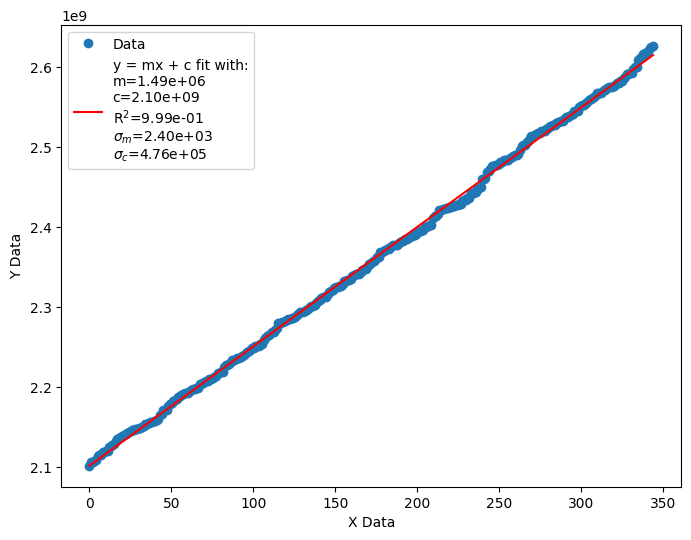

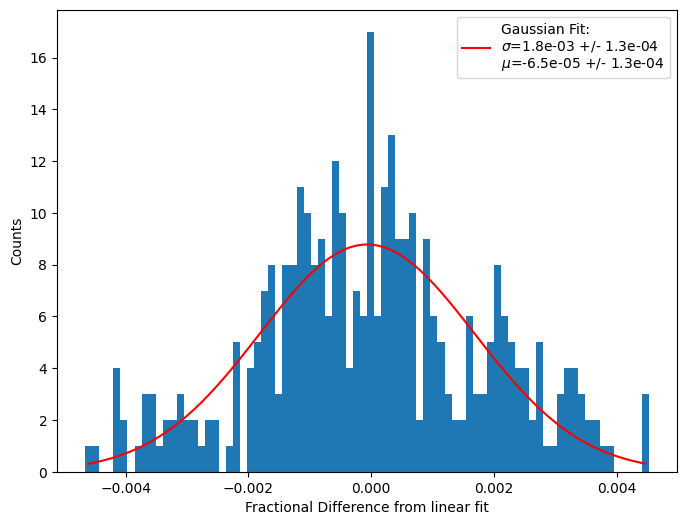

expected gradient: 1.23e+06


In [27]:
import source.util.general_analysis_tools as general_analysis_tools

n_bins = 80

index_values = np.linspace(0, reduced_f0_array.size, reduced_f0_array.size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    reduced_f0_array,
    plot_graph=True
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
fractional_difference = (reduced_f0_array - best_fit) / best_fit

difference_density, difference_bins = np.histogram(fractional_difference, density=False, bins=n_bins)
bin_centres = difference_bins[:-1] + (difference_bins[1] - difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


result = model.fit(difference_density, parameters, x=bin_centres)
result_dict = {}
for name, parameter in result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(fractional_difference, density=False, bins=n_bins)
plt.plot(bin_centres, result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={ffs_sigma:.1e} +/- {ffs_sigma_error:.1e}\n$\mu$={ffs_centre:.1e} +/- {ffs_centre_error:.1e}")
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Counts")
plt.legend()
plt.show()

expected_gradient = (expected_f0_array[-1] - expected_f0_array[0]) / expected_f0_array.size
print(f"expected gradient: {expected_gradient:.2e}")

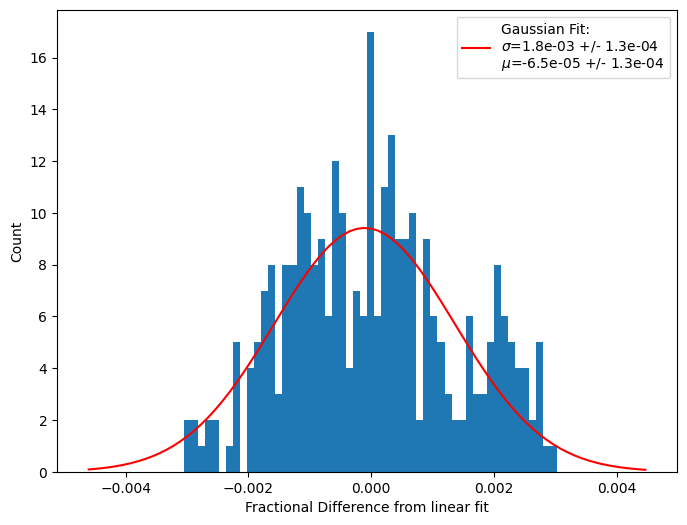

In [29]:
difference_density, difference_bins = np.histogram(fractional_difference, density=False, bins=n_bins)
bin_centres = difference_bins[:-1] + (difference_bins[1] - difference_bins[0]) / 2

tails_removed_mask = np.where((fractional_difference > -0.003) & (fractional_difference < 0.003))[0]
clipped_fractional_difference = fractional_difference[tails_removed_mask]

clipped_difference_density, clipped_difference_bins = np.histogram(clipped_fractional_difference, density=False, bins=difference_bins)
clipped_bin_centres = clipped_difference_bins[:-1] + (clipped_difference_bins[1] - clipped_difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


clipped_result = model.fit(clipped_difference_density, parameters, x=clipped_bin_centres)
result_dict = {}
for name, parameter in result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(clipped_fractional_difference, density=False, bins=clipped_difference_bins)
plt.plot(clipped_bin_centres, clipped_result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={ffs_sigma:.1e} +/- {ffs_sigma_error:.1e}\n$\mu$={ffs_centre:.1e} +/- {ffs_centre_error:.1e}")
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Count")
plt.legend()
plt.show()


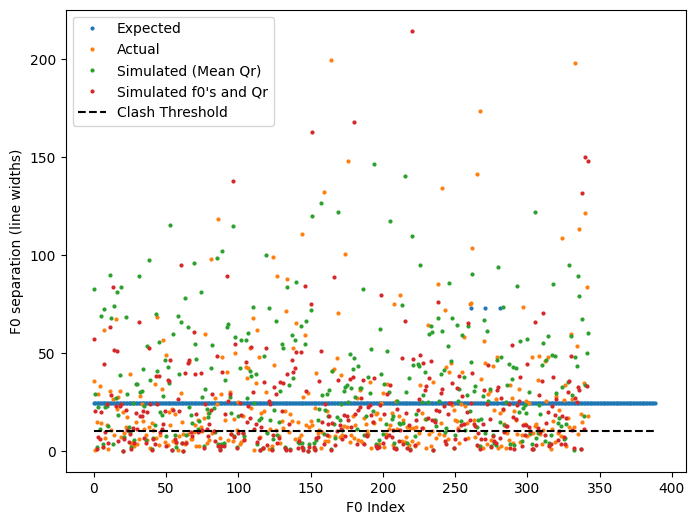

Clash probabilty out of 344 KIDs
Clashes in data: 35.6%
Clashes in simulated data with mean Qr: (25.1 +/- 5.3)%
Clashes in simulated data with simulated Qr: (36.2 +/- 5.3)%


In [11]:
expected_line_width_spacing = np.diff(expected_f0_array) / 5e4
reduced_line_width_spacing = np.diff(reduced_f0_array) / reduced_qr_array[:-1]
fake_line_width_spacing_mean = np.diff(fake_scattered_array) / (qr_centre * 1e3)
fake_line_width_spacing = np.diff(fake_scattered_array) / fake_qr_array[:-1]

plt.figure(figsize=(8, 6))
plt.plot(expected_line_width_spacing, linestyle="none", marker="o", markersize=2, label="Expected")
plt.plot(reduced_line_width_spacing, linestyle="none", marker="o", markersize=2, label="Actual")
plt.plot(fake_line_width_spacing_mean, linestyle="none", marker="o", markersize=2, label="Simulated (Mean Qr)")
plt.plot(fake_line_width_spacing, linestyle="none", marker="o", markersize=2, label="Simulated f0's and Qr")
plt.hlines(y=line_width_spacing_threshold, xmin=0, xmax=n_tones_expected, linestyles="--", color="k", label="Clash Threshold")
plt.xlabel("F0 Index")
plt.ylabel("F0 separation (line widths)")
plt.legend()
plt.show()

# Calculate clashes
actual_clashes = np.where(reduced_line_width_spacing < line_width_spacing_threshold)[0].size / reduced_line_width_spacing.size
fake_mean_clashes = np.where(fake_line_width_spacing_mean < line_width_spacing_threshold)[0].size / fake_line_width_spacing_mean.size
fake_clashes = np.where(fake_line_width_spacing < line_width_spacing_threshold)[0].size / fake_line_width_spacing.size

print(f"Clash probabilty out of {reduced_f0_array.size} KIDs")
print(f"Clashes in data: {actual_clashes * 100:.1f}%")
print(f"Clashes in simulated data with mean Qr: ({fake_mean_clashes * 100:.1f} +/- {uncertainty * 100:.1f})%")
print(f"Clashes in simulated data with simulated Qr: ({fake_clashes * 100:.1f} +/- {uncertainty * 100:.1f})%")

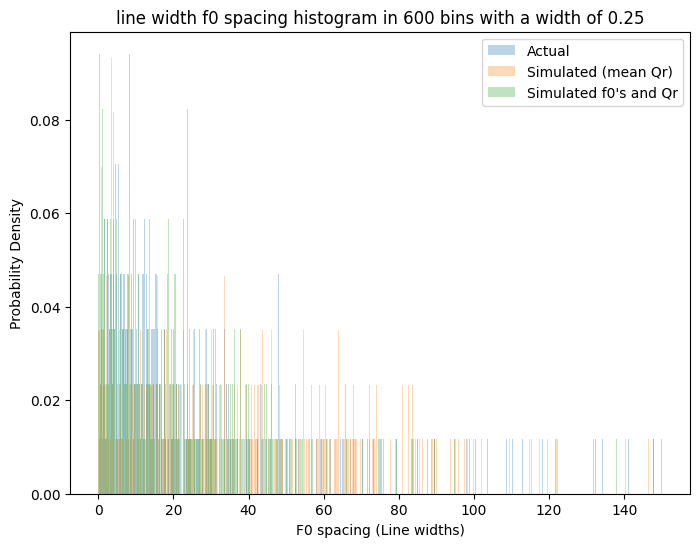

In [12]:
max_linewidth_spacing = 150
minimum_bin = math.floor(np.min([reduced_line_width_spacing, fake_line_width_spacing, fake_line_width_spacing_mean]))
maximum_bin = math.ceil(np.max([reduced_line_width_spacing, fake_line_width_spacing, fake_line_width_spacing_mean]))

# Exclude data values that are beyond range of interest:
if maximum_bin > max_linewidth_spacing:
    maximum_bin = max_linewidth_spacing
spacing_range = int((maximum_bin - minimum_bin)*4)

counts, bins = np.histogram(reduced_line_width_spacing*1e-3, bins=spacing_range, range=(minimum_bin, maximum_bin))
bin_width = (bins[1] - bins[0])

plt.figure(figsize=(8, 6))
plt.hist(reduced_line_width_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, alpha=0.3, label="Actual")
plt.hist(fake_line_width_spacing_mean, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, alpha=0.3, label="Simulated (mean Qr)")
plt.hist(fake_line_width_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, alpha=0.3, label="Simulated f0's and Qr")
plt.xlabel("F0 spacing (Line widths)")
plt.ylabel("Probability Density")
plt.title(f"line width f0 spacing histogram in {spacing_range} bins with a width of {bin_width}")
plt.legend()
plt.show()


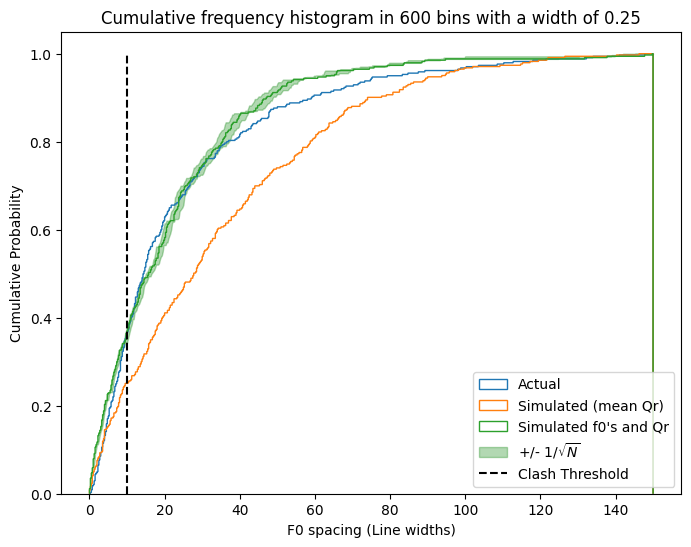

In [13]:
lower_count, lower_bins_count = np.histogram(fake_line_width_spacing*(1-uncertainty), bins=spacing_range, range=(minimum_bin, maximum_bin), density=False)
upper_count, upper_bins_count = np.histogram(fake_line_width_spacing*(1+uncertainty), bins=spacing_range, range=(minimum_bin, maximum_bin), density=False)
lower_probability_density = lower_count / sum(lower_count)
upper_probability_density = upper_count / sum(upper_count)
lower_cumulative_frequency = np.cumsum(lower_probability_density)
upper_cumulative_frequency = np.cumsum(upper_probability_density)

plt.figure(figsize=(8, 6))
plt.hist(reduced_line_width_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, cumulative=True, histtype="step", label="Actual")
plt.hist(fake_line_width_spacing_mean, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, cumulative=True, histtype="step", label="Simulated (mean Qr)")
plt.hist(fake_line_width_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, cumulative=True, histtype="step", label="Simulated f0's and Qr")
plt.fill_between(lower_bins_count[1:], y1=lower_cumulative_frequency, y2=upper_cumulative_frequency, alpha=0.3, color="g", label="+/- 1/$\sqrt{N}$")
plt.vlines(x=10, ymin=0, ymax=1, color="k", linestyle="--", label="Clash Threshold")
plt.xlabel("F0 spacing (Line widths)")
plt.ylabel("Cumulative Probability")
plt.title(f"Cumulative frequency histogram in {spacing_range} bins with a width of {bin_width}")
plt.legend(loc="lower right")
plt.show()

[0.0001     0.00031623 0.001      0.00316228 0.01      ]


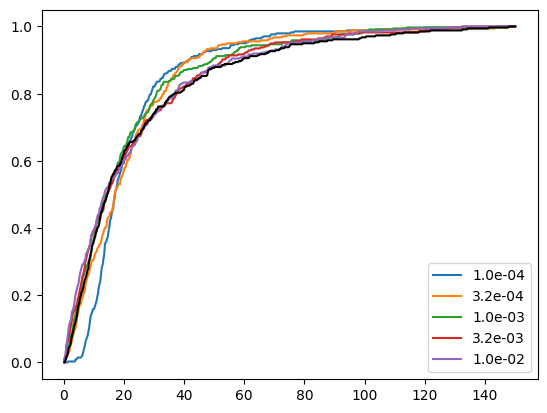

In [14]:
data_count, data_bins_count = np.histogram(reduced_line_width_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=False)
data_probability_density = data_count / sum(data_count)
data_cumulative_frequency = np.cumsum(data_probability_density)

ffs_array = np.logspace(start=-4, stop=-2, num=5)
print(ffs_array)
plt.figure()
for ffs in ffs_array:
    simulated_cumulative_density, bins = scatter_tools.linewidth_spacing_cumulative_density(
        expected_f0_array=expected_f0_array,
        fab_yield=device_yield,
        fractional_frequency_shift=ffs,
        qr_gamma=qr_gamma,
        qr_mean=qr_centre,
        qr_sigma=qr_sigma,
        histogram_bins=spacing_range,
        histogram_minimum_bin=minimum_bin,
        histogram_maximum_bin=maximum_bin,
        use_fixed_qr=False
    )
    plt.plot(bins[1:], simulated_cumulative_density, label=f"{ffs:.1e}")

plt.plot(bins[1:], data_cumulative_frequency, color="k")
plt.legend()
plt.show()

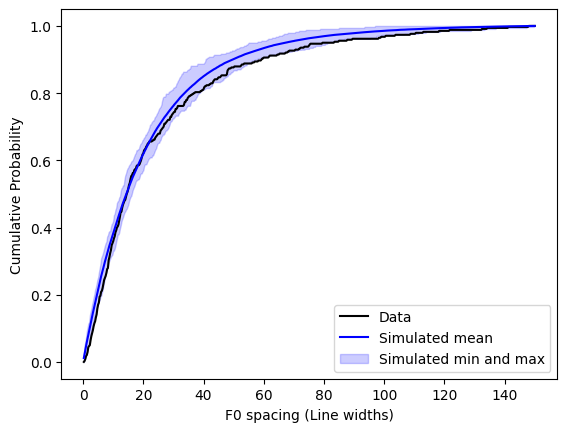

In [15]:
repeats = 100

cumulative_density_array = []
for repeat in range(repeats):
    simulated_cumulative_density, bins = scatter_tools.linewidth_spacing_cumulative_density(
        expected_f0_array=expected_f0_array,
        fab_yield=device_yield,
        fractional_frequency_shift=1e-3,
        qr_gamma=qr_gamma,
        qr_mean=qr_centre,
        qr_sigma=qr_sigma,
        histogram_bins=spacing_range,
        histogram_minimum_bin=minimum_bin,
        histogram_maximum_bin=maximum_bin,
    )
    cumulative_density_array.append(simulated_cumulative_density)

cumulative_density_array = np.array(cumulative_density_array)
mean = np.mean(cumulative_density_array, axis=0)
min = np.min(cumulative_density_array, axis=0)
max = np.max(cumulative_density_array, axis=0)

plt.figure()
plt.plot(data_bins_count[1:], data_cumulative_frequency, color="k", label="Data")
plt.plot(bins[1:], mean, alpha=1, color="b", label="Simulated mean")
plt.fill_between(bins[1:], y1=min, y2=max, color="b", alpha=0.2, label="Simulated min and max")
plt.legend()
plt.xlabel("F0 spacing (Line widths)")
plt.ylabel("Cumulative Probability")
plt.show()

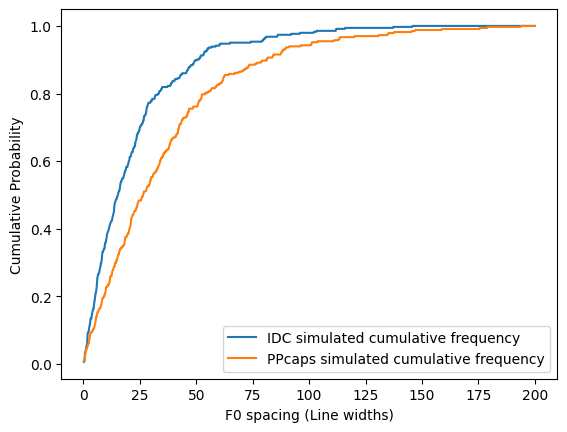

In [16]:
# Comparing cumulative frequency density between IDC and PPcaps
idc_yield=0.882
idc_fractional_frequency_shift=1e-3
idc_qr_gamma=2.4
idc_qr_mean=40.9
idc_qr_sigma=51.1
idc_histogram_bins=1200
idc_histogram_minimum_bin=0
idc_histogram_maximum_bin=200

ppcap_yield=0.854
ppcaps_fractional_frequency_shift=1e-3
ppcaps_qr_gamma=3.0
ppcaps_qr_mean=26.5
ppcaps_qr_sigma=20.7
ppcaps_histogram_bins=1200
ppcaps_histogram_minimum_bin=0
ppcaps_histogram_maximum_bin=200



idc_cumulative_density, idc_bins = scatter_tools.linewidth_spacing_cumulative_density(
    expected_f0_array=expected_f0_array,
    fab_yield=idc_yield,
    fractional_frequency_shift=idc_fractional_frequency_shift,
    qr_gamma=idc_qr_gamma,
    qr_mean=idc_qr_mean,
    qr_sigma=idc_qr_sigma,
    histogram_bins=idc_histogram_bins,
    histogram_minimum_bin=idc_histogram_minimum_bin,
    histogram_maximum_bin=idc_histogram_maximum_bin,
    use_fixed_qr=False,
)

ppcaps_cumulative_density, ppcaps_bins = scatter_tools.linewidth_spacing_cumulative_density(
    expected_f0_array=expected_f0_array,
    fab_yield=ppcap_yield,
    fractional_frequency_shift=ppcaps_fractional_frequency_shift,
    qr_gamma=ppcaps_qr_gamma,
    qr_mean=ppcaps_qr_mean,
    qr_sigma=ppcaps_qr_sigma,
    histogram_bins=ppcaps_histogram_bins,
    histogram_minimum_bin=ppcaps_histogram_minimum_bin,
    histogram_maximum_bin=ppcaps_histogram_maximum_bin,
    use_fixed_qr=False,
)

plt.figure()
plt.plot(idc_bins[1:], idc_cumulative_density, label="IDC simulated cumulative frequency")
plt.plot(ppcaps_bins[1:], ppcaps_cumulative_density, label="PPcaps simulated cumulative frequency")
plt.xlabel("F0 spacing (Line widths)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.show()

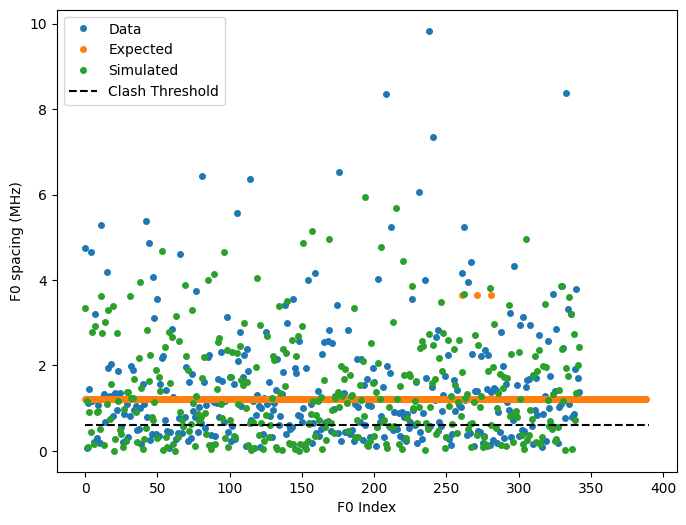

Clash probabilty out of 344 KIDs
Clashes in data: 28.9%
Clashes in simulated data with simulated Qr: (31.8 +/- 5.3)%


In [17]:
expected_f0_spacing = np.diff(expected_f0_array)
reduced_f0_spacing = np.diff(reduced_f0_array)
fake_f0_spacing = np.diff(fake_scattered_array)
clash_threshold = 0.6e6

plt.figure(figsize=(8, 6))
plt.plot(reduced_f0_spacing*1e-6, linestyle="none", marker="o", markersize=4, label="Data")
plt.plot(expected_f0_spacing*1e-6, linestyle="none", marker="o", markersize=4, label="Expected")
plt.plot(fake_f0_spacing*1e-6, linestyle="none", marker="o", markersize=4, label="Simulated")
plt.hlines(y=clash_threshold * 1e-6, xmin=0, xmax=expected_f0_array.size, color="k", linestyle="--", label="Clash Threshold")
plt.xlabel("F0 Index")
plt.ylabel("F0 spacing (MHz)")
plt.legend()
plt.show()

# Calculate clashes
actual_clashes = np.where(reduced_f0_spacing < clash_threshold)[0].size / reduced_f0_spacing.size
fake_clashes = np.where(fake_f0_spacing < clash_threshold)[0].size / fake_f0_spacing.size

print(f"Clash probabilty out of {reduced_f0_array.size} KIDs")
print(f"Clashes in data: {actual_clashes * 100:.1f}%")
print(f"Clashes in simulated data with simulated Qr: ({fake_clashes * 100:.1f} +/- {uncertainty * 100:.1f})%")

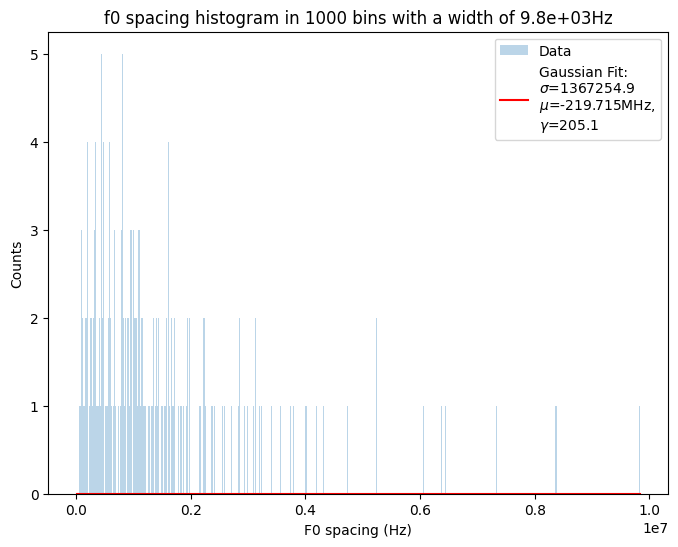

In [18]:
max_spacing = 10e6
number_of_bins = 1000
minimum_bin = math.floor(np.min([reduced_f0_spacing, fake_f0_spacing]))
maximum_bin = math.ceil(np.max([reduced_f0_spacing, fake_f0_spacing]))
# Exclude data values that are beyond range of interest:
if maximum_bin > max_spacing:
    maximum_bin = max_spacing


counts, bins = np.histogram(reduced_f0_spacing, bins=number_of_bins, range=(minimum_bin, maximum_bin), density=False)
bin_width = (bins[1] - bins[0])
bin_centres = bins[:-1] + (bins[1] - bins[0]) / 2


# Fit gaussian:
model = SkewedGaussianModel()
parameters = model.guess(counts, x=bin_centres)
result = model.fit(counts, parameters, x=bin_centres)
sigma=result.best_values["sigma"]
centre=result.best_values["center"]
gamma=result.best_values["gamma"]

plt.figure(figsize=(8, 6))
plt.hist(reduced_f0_spacing, bins=number_of_bins, range=(minimum_bin, maximum_bin), density=False, alpha=0.3, label="Data")
plt.plot(bin_centres, result.best_fit, color="r", label=f"Gaussian Fit:\n$\sigma$={sigma:.1f}\n$\mu$={centre*1e-6:.3f}MHz,\n$\gamma$={gamma:.1f}")
# plt.hist(fake_f0_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, alpha=0.3, label="Simulated")
plt.xlabel("F0 spacing (Hz)")
plt.ylabel("Counts")
plt.title(f"f0 spacing histogram in {number_of_bins} bins with a width of {bin_width:.1e}Hz")
plt.legend()
plt.show()


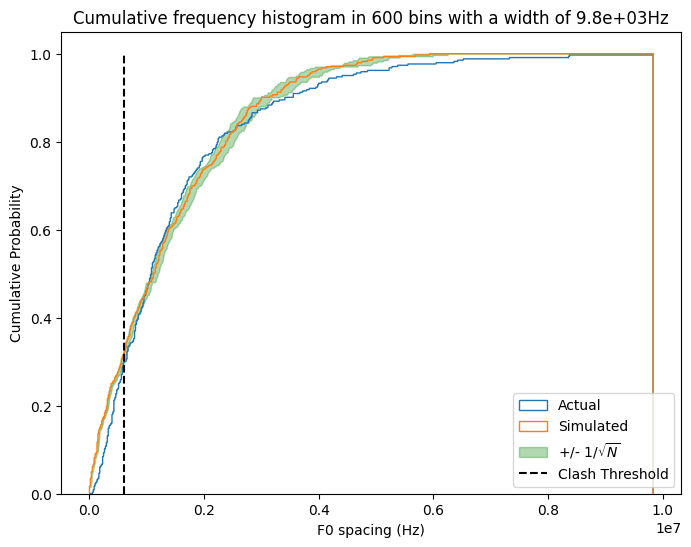

In [19]:
lower_count, lower_bins_count = np.histogram(fake_f0_spacing*(1-uncertainty), bins=spacing_range, range=(minimum_bin, maximum_bin), density=False)
upper_count, upper_bins_count = np.histogram(fake_f0_spacing*(1+uncertainty), bins=spacing_range, range=(minimum_bin, maximum_bin), density=False)
lower_probability_density = lower_count / sum(lower_count)
upper_probability_density = upper_count / sum(upper_count)
lower_cumulative_frequency = np.cumsum(lower_probability_density)
upper_cumulative_frequency = np.cumsum(upper_probability_density)

plt.figure(figsize=(8, 6))
plt.hist(reduced_f0_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, cumulative=True, histtype="step", label="Actual")
plt.hist(fake_f0_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=True, cumulative=True, histtype="step", label="Simulated")
plt.fill_between(lower_bins_count[1:], y1=lower_cumulative_frequency, y2=upper_cumulative_frequency, alpha=0.3, color="g", label="+/- 1/$\sqrt{N}$")
plt.vlines(x=clash_threshold, ymin=0, ymax=1, color="k", linestyle="--", label="Clash Threshold")
plt.xlabel("F0 spacing (Hz)")
plt.ylabel("Cumulative Probability")
plt.title(f"Cumulative frequency histogram in {spacing_range} bins with a width of {bin_width:.1e}Hz")
plt.legend(loc="lower right")
plt.show()

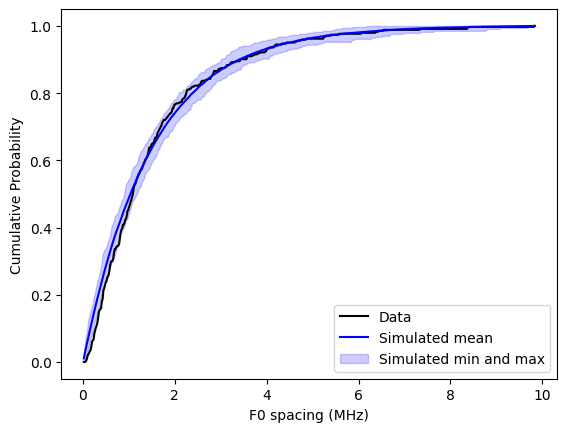

In [20]:
data_count, data_bins_count = np.histogram(reduced_f0_spacing, bins=spacing_range, range=(minimum_bin, maximum_bin), density=False)
data_probability_density = data_count / sum(data_count)
data_cumulative_frequency = np.cumsum(data_probability_density)

repeats = 100

cumulative_density_array = []
for repeat in range(repeats):
    simulated_cumulative_density, bins = scatter_tools.spacing_cumulative_density(
        expected_f0_array=expected_f0_array,
        fab_yield=device_yield,
        fractional_frequency_shift=2.17e-3,
        histogram_bins=spacing_range,
        histogram_minimum_bin=minimum_bin,
        histogram_maximum_bin=maximum_bin,
        ffs_sigma=4.0,
        repeats=1
    )
    cumulative_density_array.append(simulated_cumulative_density)

cumulative_density_array = np.array(cumulative_density_array)
mean = np.mean(cumulative_density_array, axis=0)
min = np.min(cumulative_density_array, axis=0)
max = np.max(cumulative_density_array, axis=0)

plt.figure()
plt.plot(data_bins_count[1:] * 1e-6, data_cumulative_frequency, color="k", label="Data")
plt.plot(bins[1:] * 1e-6, mean, alpha=1, color="b", label="Simulated mean")
plt.fill_between(bins[1:] * 1e-6, y1=min, y2=max, color="b", alpha=0.2, label="Simulated min and max")
plt.legend()
plt.xlabel("F0 spacing (MHz)")
plt.ylabel("Cumulative Probability")
plt.show()

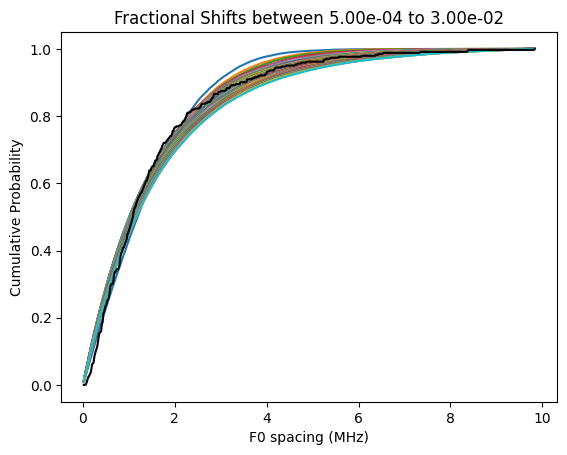

In [21]:
def get_root_mean_square_residual(expected_data: np.array, compared_data: np.array) -> float:
    n_points = expected_data.size
    residuals = compared_data - expected_data
    root_mean_square = np.sqrt(np.sum(residuals ** 2) * 1 / n_points)

    return root_mean_square

# ffs_array = np.logspace(start=-4, stop=-1.5, num=20)
ffs_array = np.linspace(start=5e-4, stop=3e-2, num=100)

rms_array = []
plt.figure()
for ffs in ffs_array:
    simulated_cumulative_density, bins = scatter_tools.spacing_cumulative_density(
        expected_f0_array=expected_f0_array,
        fab_yield=device_yield,
        fractional_frequency_shift=ffs,
        histogram_bins=spacing_range,
        histogram_minimum_bin=minimum_bin,
        histogram_maximum_bin=maximum_bin,
        repeats=100
    )
    rms = get_root_mean_square_residual(data_cumulative_frequency, simulated_cumulative_density)
    rms_array.append(rms) 
    plt.plot(bins[1:]*1e-6, simulated_cumulative_density)

rms_array = np.array(rms_array)
plt.plot(bins[1:]*1e-6, data_cumulative_frequency, color="k")
plt.xlabel("F0 spacing (MHz)")
plt.ylabel("Cumulative Probability")
plt.title(f"Fractional Shifts between {ffs_array[0]:.2e} to {ffs_array[-1]:.2e}")
plt.show()

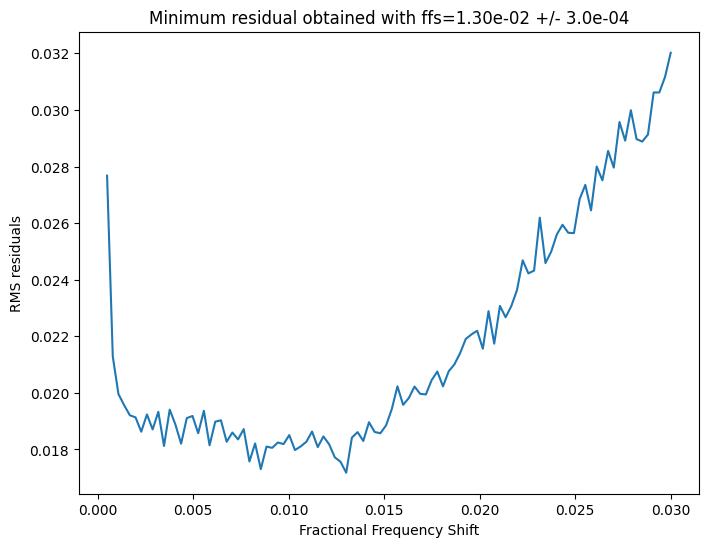

In [22]:
best_rms_index = np.argmin(rms_array)
best_ffs = ffs_array[best_rms_index]
uncertainty = (ffs_array[best_rms_index + 1] - ffs_array[best_rms_index - 1]) / 2

plt.figure(figsize=(8,6))
plt.plot(ffs_array, rms_array)
plt.xlabel("Fractional Frequency Shift")
plt.ylabel("RMS residuals")
plt.title(f"Minimum residual obtained with ffs={best_ffs:.2e} +/- {uncertainty:.1e}")
plt.show()

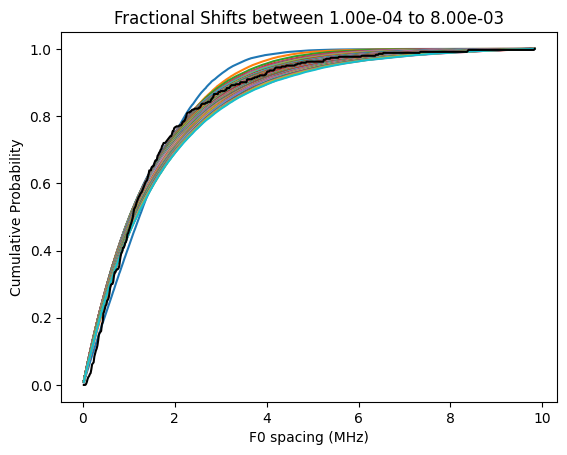

In [23]:
# ffs_array = np.logspace(start=-4, stop=-1.5, num=20)
ffs_array = np.linspace(start=1e-4, stop=8e-3, num=100)

rms_array = []
plt.figure()
for ffs in ffs_array:
    simulated_cumulative_density, bins = scatter_tools.spacing_cumulative_density(
        expected_f0_array=expected_f0_array,
        fab_yield=device_yield,
        fractional_frequency_shift=ffs,
        histogram_bins=spacing_range,
        histogram_minimum_bin=minimum_bin,
        histogram_maximum_bin=maximum_bin,
        ffs_sigma=4.0,
        repeats=100
    )
    rms = get_root_mean_square_residual(data_cumulative_frequency, simulated_cumulative_density)
    rms_array.append(rms) 
    plt.plot(bins[1:]*1e-6, simulated_cumulative_density)

rms_array = np.array(rms_array)
plt.plot(bins[1:]*1e-6, data_cumulative_frequency, color="k")
plt.xlabel("F0 spacing (MHz)")
plt.ylabel("Cumulative Probability")
plt.title(f"Fractional Shifts between {ffs_array[0]:.2e} to {ffs_array[-1]:.2e}")
plt.show()

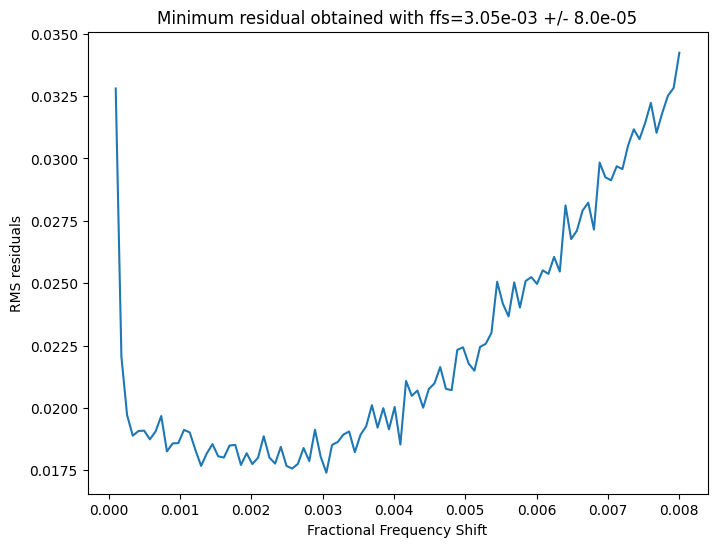

In [24]:
best_rms_index = np.argmin(rms_array)
best_ffs = ffs_array[best_rms_index]
uncertainty = (ffs_array[best_rms_index + 1] - ffs_array[best_rms_index - 1]) / 2

plt.figure(figsize=(8,6))
plt.plot(ffs_array, rms_array)
plt.xlabel("Fractional Frequency Shift")
plt.ylabel("RMS residuals")
plt.title(f"Minimum residual obtained with ffs={best_ffs:.2e} +/- {uncertainty:.1e}")
plt.show()

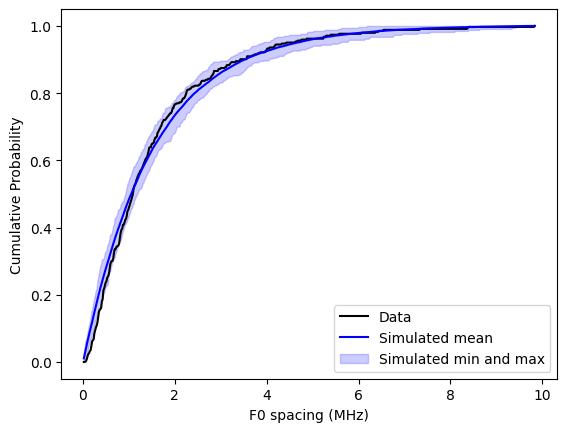

In [25]:
repeats = 100

cumulative_density_array = []
for repeat in range(repeats):
    simulated_cumulative_density, bins = scatter_tools.spacing_cumulative_density(
        expected_f0_array=expected_f0_array,
        fab_yield=device_yield,
        fractional_frequency_shift=best_ffs,
        histogram_bins=spacing_range,
        histogram_minimum_bin=minimum_bin,
        histogram_maximum_bin=maximum_bin,
        ffs_sigma=4.0,
        repeats=1
    )
    cumulative_density_array.append(simulated_cumulative_density)

cumulative_density_array = np.array(cumulative_density_array)
mean = np.mean(cumulative_density_array, axis=0)
min = np.min(cumulative_density_array, axis=0)
max = np.max(cumulative_density_array, axis=0)

plt.figure()
plt.plot(data_bins_count[1:] * 1e-6, data_cumulative_frequency, color="k", label="Data")
plt.plot(bins[1:] * 1e-6, mean, alpha=1, color="b", label="Simulated mean")
plt.fill_between(bins[1:] * 1e-6, y1=min, y2=max, color="b", alpha=0.2, label="Simulated min and max")
plt.legend()
plt.xlabel("F0 spacing (MHz)")
plt.ylabel("Cumulative Probability")
plt.show()

In [26]:
# ffs_array = np.logspace(start=-4, stop=-1.5, num=20)
repeats = 100
ffs_array = np.linspace(start=1e-4, stop=8e-3, num=100)

full_rms_array = []

for repeat in range(repeats):
    rms_array = []  
    for ffs in ffs_array:
        simulated_cumulative_density, bins = scatter_tools.spacing_cumulative_density(
            expected_f0_array=expected_f0_array,
            fab_yield=device_yield,
            fractional_frequency_shift=ffs,
            histogram_bins=spacing_range,
            histogram_minimum_bin=minimum_bin,
            histogram_maximum_bin=maximum_bin,
            ffs_sigma=4.0,
            repeats=100
        )
        rms = get_root_mean_square_residual(data_cumulative_frequency, simulated_cumulative_density)
        rms_array.append(rms)
    print(f"Repeat {repeat+1} / {repeats} Complete")

    rms_array = np.array(rms_array)
    full_rms_array.append(rms_array)


Repeat 1 / 100 Complete
Repeat 2 / 100 Complete
Repeat 3 / 100 Complete
Repeat 4 / 100 Complete
Repeat 5 / 100 Complete
Repeat 6 / 100 Complete
Repeat 7 / 100 Complete
Repeat 8 / 100 Complete
Repeat 9 / 100 Complete
Repeat 10 / 100 Complete
Repeat 11 / 100 Complete
Repeat 12 / 100 Complete
Repeat 13 / 100 Complete
Repeat 14 / 100 Complete
Repeat 15 / 100 Complete
Repeat 16 / 100 Complete
Repeat 17 / 100 Complete
Repeat 18 / 100 Complete
Repeat 19 / 100 Complete
Repeat 20 / 100 Complete
Repeat 21 / 100 Complete
Repeat 22 / 100 Complete
Repeat 23 / 100 Complete
Repeat 24 / 100 Complete
Repeat 25 / 100 Complete
Repeat 26 / 100 Complete
Repeat 27 / 100 Complete
Repeat 28 / 100 Complete


KeyboardInterrupt: 

In [ ]:
standard_error = np.std(full_rms_array, axis=0) / np.sqrt(repeats)
ffs_mean = np.mean(full_rms_array, axis=0)

best_rms_index = np.argmin(ffs_mean)
best_ffs = ffs_array[best_rms_index]
uncertainty = (ffs_array[best_rms_index + 1] - ffs_array[best_rms_index - 1]) / 2

plt.figure(figsize=(8,6))
plt.plot(ffs_array, ffs_mean, color="k", linewidth=1)
plt.fill_between(ffs_array, ffs_mean - standard_error, ffs_mean + standard_error, label="Standard Error Range", alpha=1)
plt.xlabel("Fractional Frequency Scatter")
plt.ylabel("RMS residuals")
plt.title(f"Minimum residual obtained with ffs={best_ffs:.2e} +/- {uncertainty:.1e}")
plt.show()